In [1]:
import numpy             as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize      import fsolve, curve_fit
from scipy.integrate     import odeint, quad
from scipy.interpolate   import interp1d
from scipy.misc          import derivative
import scipy.constants   as const
import sympy             as sp
sp.init_printing()
import glob
import math
import alpaca_trade_api as tradeapi
from alpaca_trade_api import StreamConn
import threading
import time
import datetime
import logging
import argparse
import time
import pandas as pd
ALPACA_BASE_URL ='https://paper-api.alpaca.markets';
KEY = 'PK6Q22HTB5JPL4O35ZHM'
SCRKEY = 'sqv5r84hE7j1rqDVtUH5yC9qUEhJoND07DvuK3mG'

from lxml import html
import requests
import json
import argparse
from collections import OrderedDict

import talib as tlb
import scipy.stats as stat

### BREAK 

In [126]:
def glass_window_plot(symbol,period=10,num=390):
    #OHLC
    api    = tradeapi.REST(KEY, SCRKEY, ALPACA_BASE_URL, api_version='v2')
    sb     = api.get_barset(symbol, 'minute', limit = num).df
    prices = {}
    A      = ['close','open','high','low','volume']
    for a in A:
        prices[a]=sb[symbol][a]
    for i in range(len(prices['close'])):
        if prices['close'][i]==0:
            prices['close'][i]=prices['close'][i-1]
    #BOLLINGER BANDS    
    up,mid,lwr = tlb.BBANDS(prices['close'],period,nbdevup=1.8,nbdevdn=1.8,matype=1)
    up,mid,lwr = up[period:],mid[period:],lwr[period:]
    #RSI
    RSI = tlb.RSI(prices['close'], timeperiod=period)
    RSI = RSI[period:]
    levels = [1,5,10,25,50,75,90,95,99]
    B = stat.scoreatpercentile(RSI, [1,5,10,25,50,75,90,95,99])
    RSI_level = []
    for current in RSI:
        RSI_level.append(stat.percentileofscore(RSI,current))
        
        
    ##SIMULATOR
    buy  = np.zeros(num-period)
    sell = np.zeros(num-period)
    quantity = 0
    delay   = 1
    for i in range(num-period):        
        if up[i]<=prices['close'][i+period] and RSI_level[i]<80:
            buy[i]=prices['close'][i+period+delay]*2
            quantity+=2
        
        if RSI_level[i]<20:
            buy[i]=buy[i]+prices['close'][i+period+delay]*2
            quantity+=2
            
        if prices['close'][i+period]<lwr[i] and quantity>0:
            sell[i]=prices['close'][i+period+delay]*quantity
            quantity=0
            
       # if RSI_level[i]>90 and quantity>0:
       #     sell[i]=sell[i]+prices['close'][i+period]*quantity
       #     quantity=0
 
    #cash
    cash = []
    cash.clear()
    for i in range(len(buy)):
        cash.append(sell[i]-buy[i])
    
    cash_profit = sum(sell)-sum(buy)
    print('cash profit =', cash_profit)
    
    profit = cash_profit+quantity*prices['close'][-1]
    print('The profit=', profit)
    
    #cumulative cash flow
    cum_cash = []
    cum_cash.clear()
    for i in range(len(buy)):
        cum_cash.append(sum(cash[0:i]))
    
    #RETURN ON MONEY
    Rom = -profit/min(cum_cash)
    print('ROM = ',Rom*100, '%') #
    
    
    #PLOTTING
    t = np.linspace(0,len(up),len(up))
    w,h = 20,10
    
         #plotting the profit
    plt.figure(figsize=(w,h))
    plt.title('cum cash flow', fontsize=20)
    plt.plot(cum_cash)
    plt.xticks(np.linspace(0,len(up),20),fontsize=20,rotation=45)
    plt.yticks(fontsize=20)
    plt.xlim(period,t[-1])
    plt.legend(fontsize=20)
    plt.grid()
    
        #plotting the profit
    plt.figure(figsize=(w,h))
    plt.title('cash flow', fontsize=20)
    plt.plot(cash)
    plt.xticks(np.linspace(0,len(up),20),fontsize=20,rotation=45)
    plt.yticks(fontsize=20)
    plt.xlim(period,t[-1])
    plt.legend(fontsize=20)
    plt.grid()
    
    plt.figure(figsize=(w,h))
    plt.plot(t,prices['close'][period:],label='close')
    plt.plot(t,up,'.',color='green',label='up')
    plt.plot(t,mid,'.',color='orange',label='mid')
    plt.plot(t,lwr,'.',color='red',label='low')
    plt.legend(fontsize=20)
    plt.xticks(np.linspace(0,len(up),20),fontsize=20,rotation=45)
    plt.yticks(fontsize=20)
    plt.xlim(period,t[-1])
    plt.grid()
     
    plt.figure(figsize=(w,h))
    plt.plot(t,RSI,label='RSI')
    plt.yticks(fontsize=20)
    plt.xlim(period,t[-1])
    plt.legend(fontsize=20)
    plt.grid()
    
    plt.figure(figsize=(w,h))
    plt.plot(t,RSI_level,label='RSI')
    for i,b in enumerate(B,0):
        plt.plot(t,np.ones(len(t))*b,label=f'{levels[i]} % Percentil' )
    plt.xticks(np.linspace(0,len(up),20),fontsize=20,rotation=45)
    plt.yticks(fontsize=20)
    plt.xlim(period,t[-1])
    #plt.legend(fontsize=20)
    plt.grid()
    
    plt.figure(figsize=(w,h))
    plt.plot(t,prices['volume'][period:],label='volume',color='green')
    plt.xticks(np.linspace(0,len(up),20),fontsize=20,rotation=45)
    plt.yticks(fontsize=20)
    plt.xlim(period,t[-1])
    plt.legend(fontsize=20)
    plt.grid()
    
    df = pd.DataFrame(np.array([buy,sell,cum_cash]).T, columns=['buy','sell','cumulative cash flow'])
    return df

No handles with labels found to put in legend.
No handles with labels found to put in legend.


cash profit = -28.040000000001783
The profit= 54.65999999999822
ROM =  4.640777028747873 %


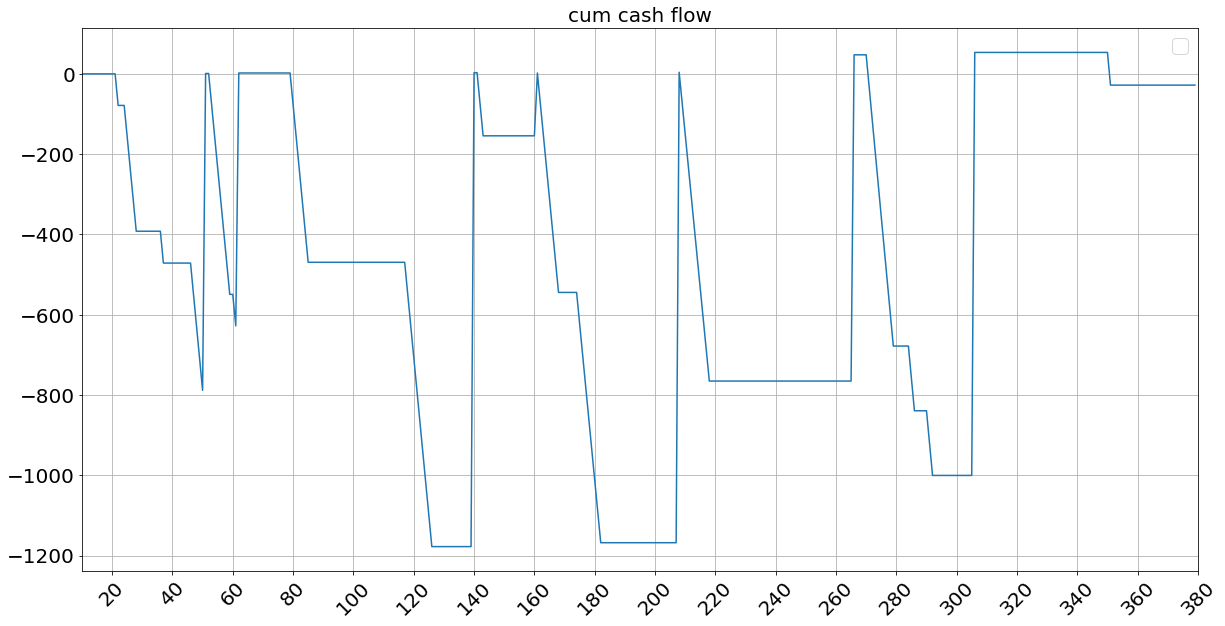

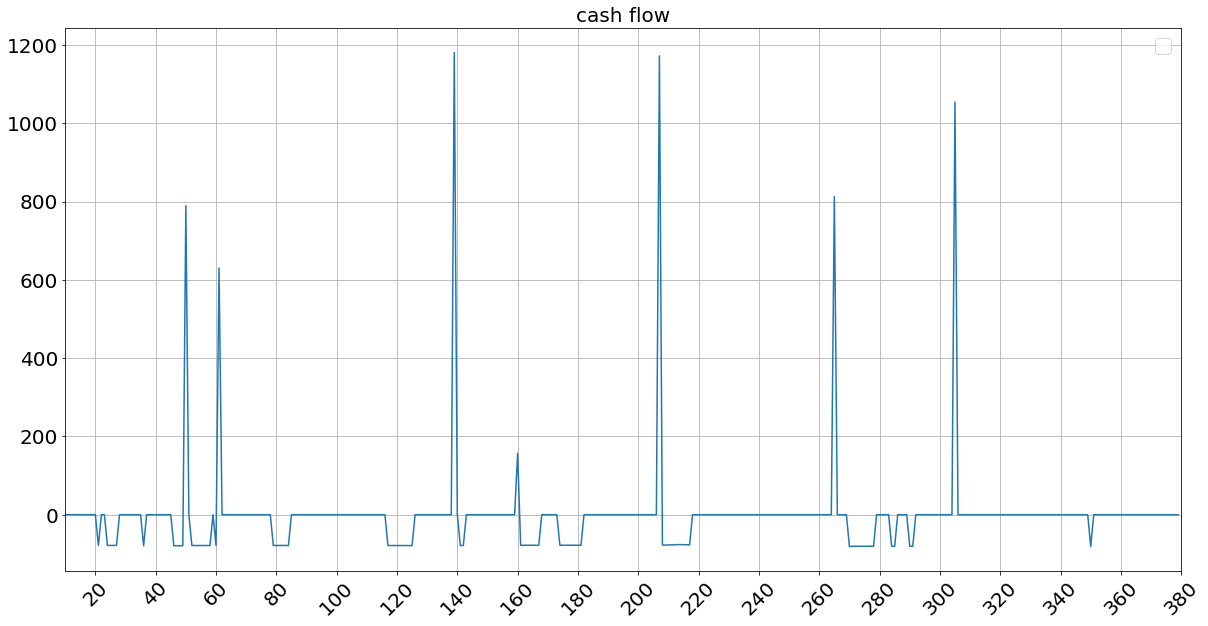

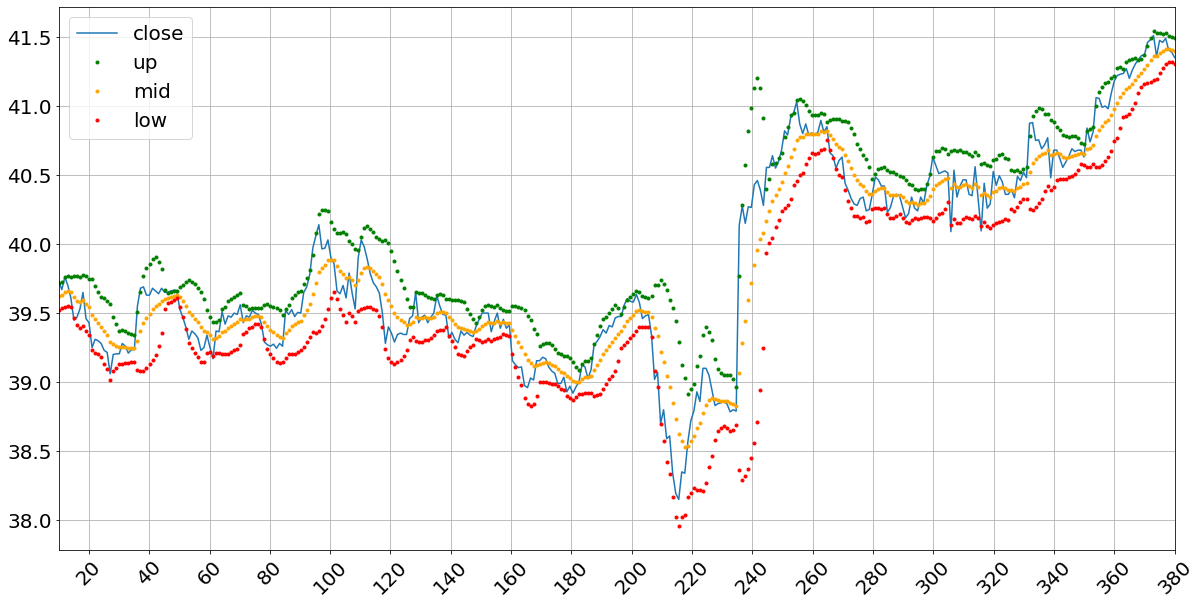

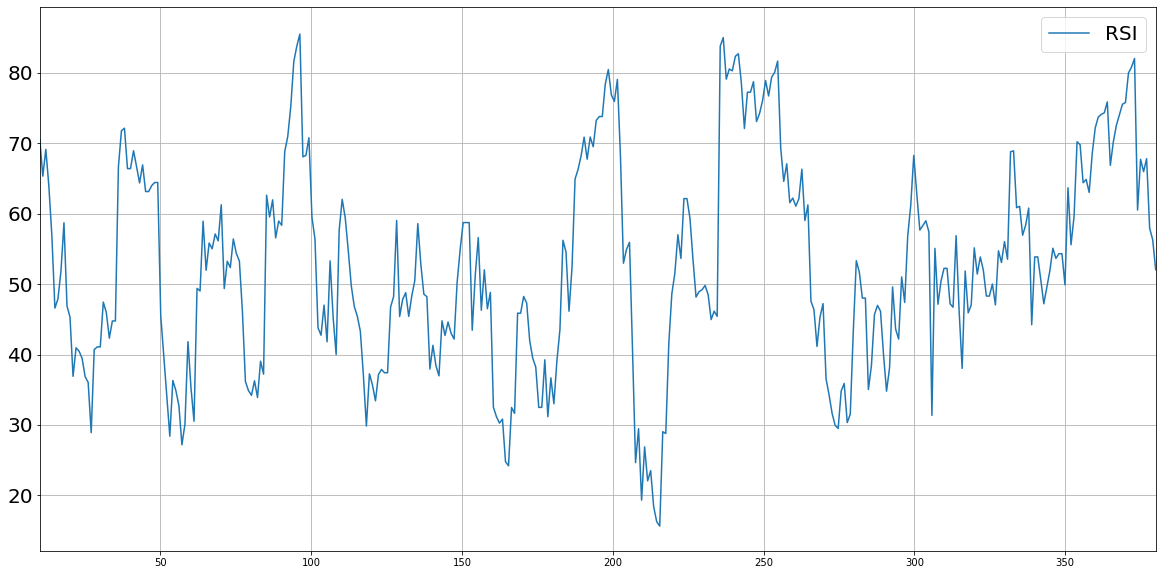

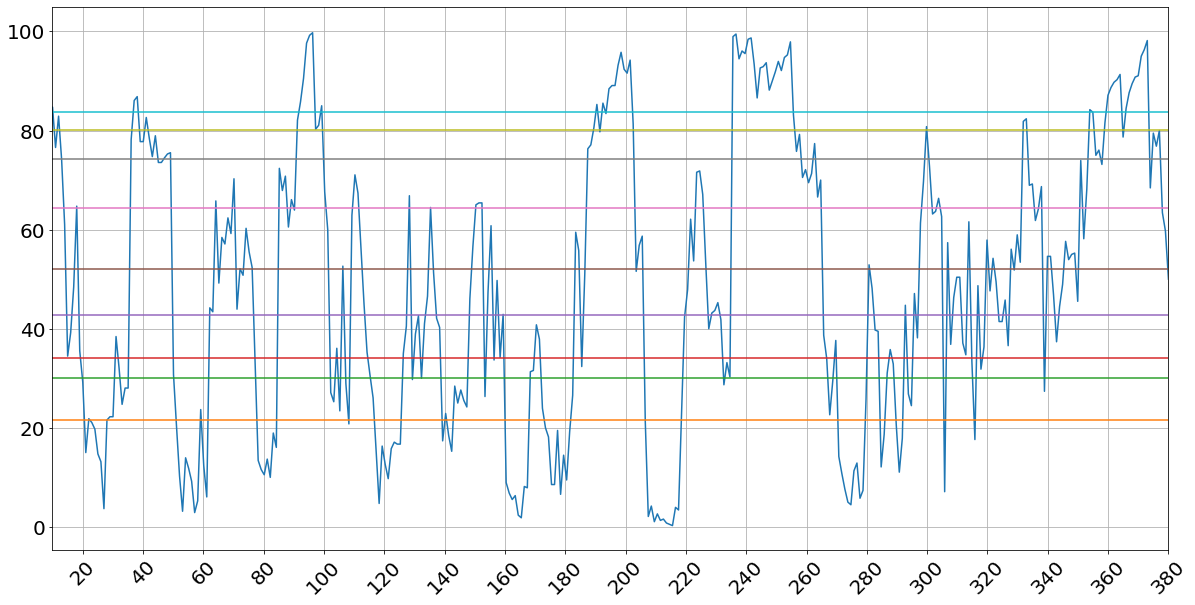

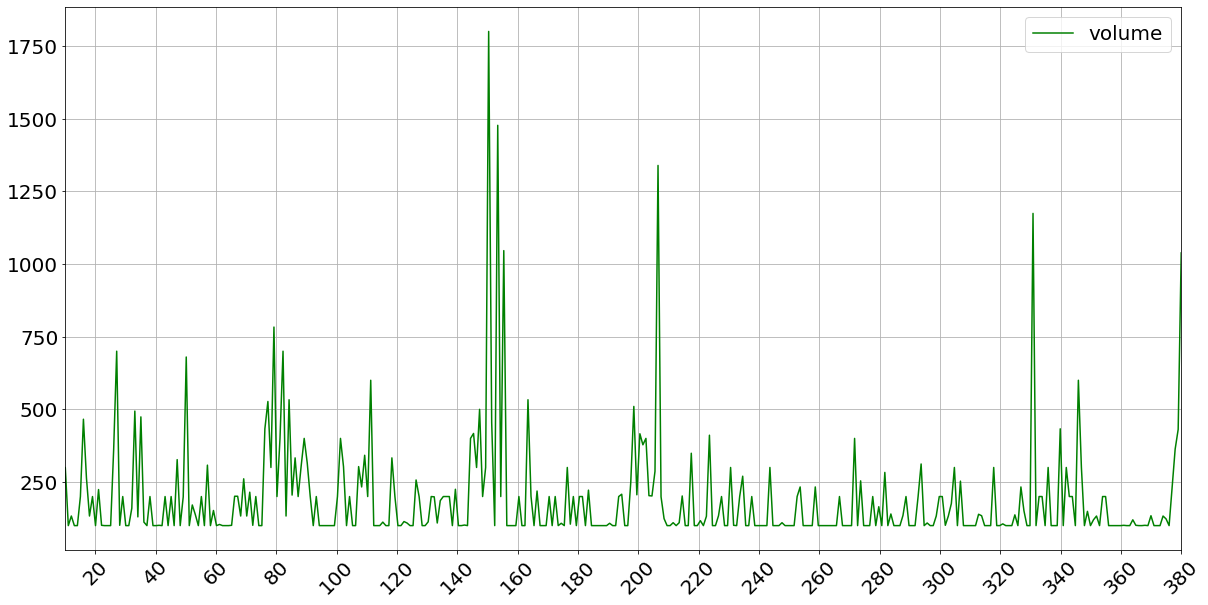

In [129]:
o=glass_window_plot('SCHN')

In [31]:
import os

import requests

TECHNICAL_ANALYSIS_SMA_KEY = 'Technical Analysis: SMA'
SMA_KEY = 'SMA'




def plotting_close(symbol, time_period):
    function_param = 'function=TIME_SERIES_INTRADAY'
    symbol_param = 'symbol={}'.format(symbol)
    interval_param = 'interval=5min'
    size_param = 'outputsize=full'
    alpha_vantage_api_key = KEY
    api_key_param = 'apikey={}'.format(alpha_vantage_api_key)
    api_url = 'https://www.alphavantage.co/query?{}&{}&{}&{}&{}'.format(function_param,
                                                                           symbol_param,
                                                                           interval_param,
                                                                           size_param,
                                                                           api_key_param)
    return api_url

def plot_it(symbol,time_period=50):
    api = plotting_close(symbol,time_period)
    results = []
    response = requests.get(api)
    
    #df = pd.DataFrame(results)
    plt.plot(df['date'],df['value']);
    
#####################################################################

def _prepare_api_url(symbol, time_period):
    function_param = 'function=SMA'
    symbol_param = 'symbol={}'.format(symbol)
    interval_param = 'interval=5min'
    time_period_param = 'time_period={}'.format(time_period)
    series_type_param = 'series_type=close'
    alpha_vantage_api_key = KEY
    api_key_param = 'apikey={}'.format(alpha_vantage_api_key)
    api_url = 'https://www.alphavantage.co/query?{}&{}&{}&{}&{}&{}'.format(function_param,
                                                                           symbol_param,
                                                                           interval_param,
                                                                           time_period_param,
                                                                           series_type_param,
                                                                           api_key_param)
    return api_url

def simple_moving_average(symbol, time_period=50):
    api_url = _prepare_api_url(symbol, time_period)
    results = []
    response = requests.get(api_url)
    if response.status_code == requests.codes.ok:
        api_result = response.json()
        if TECHNICAL_ANALYSIS_SMA_KEY in api_result:
            sma_dict = api_result[TECHNICAL_ANALYSIS_SMA_KEY]
            for date_key in sorted(sma_dict):
                sma_value = sma_dict[date_key][SMA_KEY]
                observation = {
                    'date': date_key,
                    'value': float(sma_value)
                }
                results.append(observation)

    return results

In [5]:
plot_it('TSLA')

NameError: name 'df' is not defined

In [ ]:
SMA = simple_moving_average('TSLA')
df = pd.DataFrame(SMA)
plt.plot(df['date'],df['value']);
#xticks

In [ ]:
df.tail()